# Sketch

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import random
from torch import nn

In [ ]:
class MyGraph:
    def __init__(self, width: int = 5, height: int = 5):
        self.width = width  # y-axis
        self.height = height  # x-axis
        self.G = nx.generators.lattice.grid_2d_graph(self.height, self.width)
        self.adj_matrix = nx.adjacency_matrix(self.G).toarray()
        self.nodes_list = list(self.G.nodes.keys())
        self.edge_indices = self.calc_node_action_pairs()
        self.action_dim = None
        self.state_dim = None
        self.action_method = None
        self.state_method = None

    def calc_node_action_pairs(self) -> dict[(int, int) : int]:
        edge_indices = {}
        for edge_idx, edge in enumerate(self.G.edges()):
            from_node, to_node = edge
            from_node_idx = self.nodes_list.index(from_node)
            to_node_idx = self.nodes_list.index(to_node)
            edge_indices[(from_node_idx, to_node_idx)] = edge_idx * 2
            edge_indices[(to_node_idx, from_node_idx)] = edge_idx * 2 + 1
        return edge_indices

    def calc_action_between_cur_and_next_node(
        self, curr_node: int, next_node: int
    ) -> int:
        """
        each node has 4 actions: [S, N, W, E]
        """
        curr_x, curr_y = self.nodes_list[curr_node]
        next_x, next_y = self.nodes_list[next_node]
        origin_neighbors = [
            (curr_x + 1, curr_y),
            (curr_x - 1, curr_y),
            (curr_x, curr_y - 1),
            (curr_x, curr_y + 1),
        ]
        action = origin_neighbors.index((next_x, next_y))
        return action

    def random_walk(
        self, num_walks, walk_length, action_method: int = 0, state_method: int = 0
    ):
        """
        action_method:
            0: state-dependent action
            1: state-independent action (4 action)
        state_method:
            0: coordinate-independent state
            1: coordinate-dependent state (x, y)
        """
        self.action_method = action_method
        self.state_method = state_method
        if action_method == 0:  # state-dependent action
            self.action_dim = len(self.edge_indices)
        elif action_method == 1:  # state-independent action (4 action)
            self.action_dim = 4
        else:
            raise AttributeError
        if state_method == 0:  # coordinate-independent state
            self.state_dim = len(self.nodes_list)
        elif state_method == 1:  # coordinate-dependent state (x, y)
            self.state_dim = 2
        else:
            raise AttributeError
        dataset = []
        for _ in range(num_walks):
            curr_node = np.random.choice(len(self.nodes_list))
            for _ in range(walk_length):
                next_node = np.random.choice(
                    np.where(self.adj_matrix[curr_node] != 0)[0]
                ).item()
                action = self.action_node_to_emb(curr_node, next_node)
                curr_node_emb = self.state_int_to_emb(curr_node)
                next_node_emb = self.state_int_to_emb(next_node)
                dataset.append(np.concatenate([curr_node_emb, [action], next_node_emb]))
                curr_node = next_node
        return np.array(dataset)

    def state_int_to_emb(self, state: int) -> np.array:
        if self.state_method == 0:  # coordinate-independent state
            state_emb = np.zeros(self.state_dim)
            state_emb[state] = 1
        elif self.state_method == 1:  # coordinate-dependent state (x, y)
            state_emb = np.array(self.nodes_list[state])
        else:
            raise AttributeError
        return state_emb.astype(np.float32)

    def action_node_to_emb(self, curr_node: int, next_node: int) -> int:
        if self.action_method == 0:  # state-dependent action
            action = self.edge_indices[(curr_node, next_node)]
        elif self.action_method == 1:  # state-independent action (4 action)
            action = self.calc_action_between_cur_and_next_node(curr_node, next_node)
        else:
            raise AttributeError
        return action

In [3]:
my_graph = MyGraph()
num_walks = 200
walk_length = 32
dataset = my_graph.random_walk(num_walks, walk_length, 0, 0)
dataset[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 23.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [4]:
class GraphDataset(Dataset):
    def __init__(self, dataset, n_obs):
        self.from_node = torch.from_numpy(dataset[:, :n_obs]).type(torch.float32)
        self.to_node = torch.from_numpy(dataset[:, n_obs + 1 :]).type(torch.float32)
        self.action = torch.from_numpy(dataset[:, n_obs]).type(torch.int)

    def __getitem__(self, index):
        return self.from_node[index], self.action[index], self.to_node[index]

    def __len__(self):
        return len(self.from_node)

In [5]:
n_obs = my_graph.state_dim
n_act = my_graph.action_dim
emb_dim = 4000
Q_init_stddev = 0.1
V_init_stddev = 0.01
W_init_stddev = 0.01
eta_q = 0.1
eta_v = 0.01
eta_w = 0.01
num_epochs = 10
batch_size = 32
dataset_torch = GraphDataset(dataset, n_obs)
n_obs, n_act

(25, 80)

In [ ]:
# state_method = action_method = 1
n_obs = my_graph.state_dim
n_act = my_graph.action_dim
emb_dim = 4000
Q_init_stddev = 0.01
V_init_stddev = 0.001
W_init_stddev = 0.001
eta_q = 0.01
eta_v = 0.001
eta_w = 0.001
num_epochs = 10
batch_size = 32
dataset_torch = GraphDataset(dataset, n_obs)
n_obs, n_act

In [6]:
# torch.manual_seed(0)
Q = torch.randn(size=(emb_dim, n_obs)) * Q_init_stddev
V = torch.randn(size=(emb_dim, n_act)) * V_init_stddev
W = torch.randn(size=(n_act, emb_dim)) * W_init_stddev
Q

tensor([[ 0.0517,  0.0921,  0.0077,  ...,  0.0688,  0.1927,  0.1626],
        [ 0.0429, -0.1249,  0.0296,  ...,  0.0162, -0.1336, -0.0329],
        [-0.1020, -0.1077, -0.0283,  ..., -0.0370,  0.0743, -0.0323],
        ...,
        [-0.0342, -0.0511, -0.0457,  ..., -0.0788, -0.0121,  0.0921],
        [-0.1231,  0.0320, -0.1718,  ..., -0.0253, -0.0355,  0.1184],
        [ 0.0105, -0.0186,  0.3327,  ..., -0.0776,  0.0984, -0.0707]])

In [7]:
loader = DataLoader(dataset_torch, shuffle=True, batch_size=batch_size)
mses1 = []

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(loader):
        # print(i)
        nodes, action, next_nodes = data
        actions = torch.zeros((V.shape[1], len(action)))
        for idx, edge in enumerate(action):
            actions[edge, idx] = 1

        s_curr_DxL = Q @ nodes.T
        s_next_DxL = Q @ next_nodes.T

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V @ actions

        V += eta_v * pred_err_DxL @ actions.T
        # Q += eta_q * s_curr_DxL @ (nodes - (Q.T @ s_curr_DxL).T) / batch_size
        Q += eta_q * pred_err_DxL @ (-next_nodes)
        W[action, :] += eta_w * s_diff_DxL.T
        V /= torch.linalg.norm(V, axis=0)
        mses1.append((pred_err_DxL**2).mean())

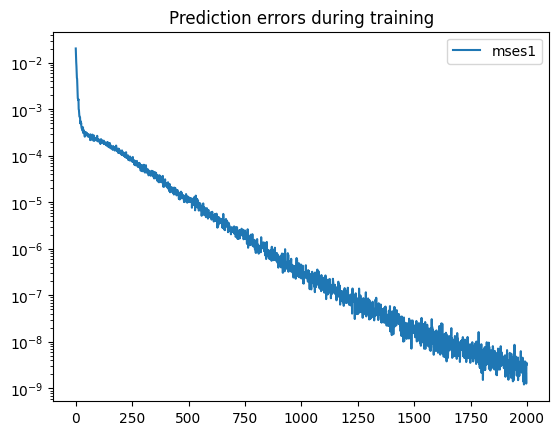

In [ ]:
fig, ax = plt.subplots()
ax.plot(mses1, label="mses1")
ax.set_title("Prediction errors during training")
ax.set_yscale("log")
plt.legend()
plt.show()
plt.close(fig)

In [ ]:
def CML_planner(graph: MyGraph, Q, V, start, goal):
    node_record = []
    curr = int(start)
    goal_node_emb = graph.state_int_to_emb(goal)
    for i in range(len(my_graph.nodes_list)):
        node_record.append(curr)
        if curr == goal:
            return i, node_record
        curr_node_emb = graph.state_int_to_emb(curr)
        delta = (
            Q @ goal_node_emb - Q @ curr_node_emb
        )  # TODO: start and goal are one-hot vector
        avail_nodes = np.where(graph.adj_matrix[curr] != 0)[0]  # int64
        avail_actions = [
            graph.action_node_to_emb(curr, next_node) for next_node in avail_nodes
        ]
        utility = delta.T @ V[:, avail_actions]
        eligibility = utility / graph.adj_matrix[curr][avail_nodes]
        dtype = [("id", int), ("value", float)]
        values = [(idx, value) for idx, value in enumerate(eligibility)]
        a = np.array(values, dtype=dtype)
        sorted_arr = np.sort(a, order="value")
        sorted_arr = sorted_arr[::-1]  # reverse
        for best_id, _ in sorted_arr:
            curr = int(avail_nodes[best_id])
            if curr not in node_record:
                break
    return i, node_record

In [ ]:
cml_distance = []
dijkstra_distance = []
graph = nx.from_numpy_array(my_graph.adj_matrix, create_using=nx.DiGraph())
start = my_graph.nodes_list.index((0, 0))
goal = my_graph.nodes_list.index((4, 4))
steps, o_record = CML_planner(my_graph, Q, V, start, goal)
dijkstra_path = nx.shortest_path(graph, source=start, target=goal, weight="weight")
print(o_record, dijkstra_path)
dijkstra_steps = len(dijkstra_path) - 1
cml_distance.append(steps)
dijkstra_distance.append(dijkstra_steps)
# cml_distance, dijkstra_distance
np.mean(cml_distance), np.mean(dijkstra_distance)

[0, 5, 6, 11, 12, 17, 18, 23, 24] [0, 1, 2, 3, 4, 9, 14, 19, 24]


/tmp/ipykernel_66816/3531001057.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  delta = Q@goal_node_emb - Q@curr_node_emb  # TODO: start and goal are one-hot vector
/tmp/ipykernel_66816/3531001057.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  utility = delta.T@V[:, avail_actions]
/tmp/ipykernel_66816/3531001057.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eligibility = utility / graph.adj_matrix[curr][avail_nodes]


(np.float64(8.0), np.float64(8.0))

In [ ]:
N_goal = 200
cml_distance = []
dijkstra_distance = []
graph = nx.from_numpy_array(
    my_graph.adj_matrix, create_using=nx.DiGraph()
)  # node_id is int, or else dijkstra will fail
for _ in range(N_goal):
    start = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
    goal = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
    steps, o_record = CML_planner(my_graph, Q, V, start, goal)
    dijkstra_path = nx.shortest_path(graph, source=start, target=goal, weight="weight")
    print(o_record, dijkstra_path)
    dijkstra_steps = len(dijkstra_path) - 1
    cml_distance.append(steps)
    dijkstra_distance.append(dijkstra_steps)
# cml_distance, dijkstra_distance
np.mean(cml_distance), np.mean(dijkstra_distance)

[22, 17, 12, 13, 8, 3, 4] [22, 17, 12, 7, 2, 3, 4]
[1, 6, 11, 16, 17, 22] [1, 2, 7, 12, 17, 22]
[22, 17, 12, 7, 8, 3] [22, 17, 12, 7, 2, 3]
[9, 14, 13, 12, 17] [9, 8, 7, 12, 17]
[19, 18, 17, 12, 11, 6] [19, 14, 9, 8, 7, 6]
[2, 3, 4, 9] [2, 3, 4, 9]
[23, 22, 17, 16, 11, 10] [23, 18, 13, 12, 11, 10]
[23, 18] [23, 18]
[19, 14, 9, 4, 3] [19, 14, 9, 4, 3]
[23, 18, 13, 8, 3] [23, 18, 13, 8, 3]
[11] [11]
[8, 13, 12, 11, 16, 21, 20] [8, 7, 6, 5, 10, 15, 20]
[6, 7, 12, 13, 14, 19] [6, 7, 8, 9, 14, 19]
[11] [11]
[22, 17, 12, 7, 6, 1] [22, 17, 12, 7, 2, 1]
[17, 22, 23] [17, 18, 23]
[11, 12, 17, 18, 23, 24] [11, 12, 13, 14, 19, 24]
[11, 12, 13] [11, 12, 13]
[5, 6, 11, 12, 17, 18, 23, 24] [5, 6, 7, 8, 9, 14, 19, 24]
[13, 12, 17] [13, 12, 17]
[21, 16, 11, 6, 1] [21, 16, 11, 6, 1]
[19, 18, 13, 12, 7, 6, 5, 0] [19, 14, 9, 4, 3, 2, 1, 0]
[6, 11, 12] [6, 7, 12]
[13, 18] [13, 18]
[13, 12, 11, 6] [13, 8, 7, 6]
[19] [19]
[7, 12, 17, 22, 23] [7, 8, 13, 18, 23]
[6, 7, 12, 13, 14, 19] [6, 7, 8, 9, 14, 19]
[14

/tmp/ipykernel_66816/3531001057.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  delta = Q@goal_node_emb - Q@curr_node_emb  # TODO: start and goal are one-hot vector
/tmp/ipykernel_66816/3531001057.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eligibility = utility / graph.adj_matrix[curr][avail_nodes]


(np.float64(3.4), np.float64(3.4))